In [1]:
from classes.Navigation import Navigation

navigation = Navigation('5_2_classification_newbies.ipynb')

navigation.display_header()

[Главная](./1_main.ipynb) &raquo; Построение прогноза для данных из таблицы `data_newbies`

# Построение прогноза для данных из таблицы `data_newbies`

## Оглавление
- [Загрузка данных](#item_load)
- [Логистическая регрессия](#item_lr)
    - [Использование параметров по умолчанию](#item_lr_default)
    - [Подбор параметра `C` с помощью графика](#item_lr_grafic)
    - [Подбор параметров с помощью `optuna`](#item_lr_optuna)
- [Дерево решений](#item_dtc)
    - [Использование параметров по умолчанию](#item_dtc_default)
    - [Подбор параметра `max_depth` с помощью графика](#item_dtc_grafic)
    - [Подбор параметров с помощью `optuna`](#item_dtc_optuna)
- [Случайный лес](#item_rfc)
    - [Использование параметров по умолчанию](#item_rfc_default)
    - [Подбор параметра `max_depth` с помощью графика](#item_rfc_grafic)
    - [Подбор параметров с помощью `optuna`](#item_rfc_optuna)
- [Градиентный бустинг](#item_gbc)
    - [Использование параметров по умолчанию](#item_gbc_default)
    - [Подбор параметра `max_depth` с помощью графика](#item_gbc_grafic)
    - [Подбор параметров с помощью `optuna`](#item_gbc_optuna)
- [Стекинг](#item_sc)
    - [Использование параметров метамодели по умолчанию](#item_sc_default)
    - [Подбор параметра `max_depth` с помощью графика](#item_sc_grafic)
    - [Подбор параметров метамодели с помощью `optuna`](#item_sc_optuna)
- [Выводы](#item_results)

## Загрузка данных <a id="item_load"></a>

In [2]:
# Импорт библиотек
import time
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    StackingClassifier,
)
from sklearn import metrics

import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

from warnings import simplefilter
simplefilter('ignore')

from classes.PrepareDataNewbies import PrepareDataNewbies
from functions.constants import (
    RANDOM_STATE,
    MAX_ITER,
    ATTEMPTS_COUNT,
    CV,
    N_JOBS,
)
from functions.helpers import get_exec_time
from functions.graphics import show_dependence_of_model_parameters
from functions.display_content import (
    display_f1_score,
    display_optuna_info,
    display_exec_time,
    display_metrics_results,
)

In [3]:
# Загрузим данные
data_source = pd.read_csv('./data/bank_fin.csv', sep=';')

prepareData = PrepareDataNewbies(data_source)

# Получим данные, подготовленные для использования в модели
X_train, X_test, y_train, y_test = prepareData.get_specific_data_for_model()

Создадим словари, в которые будем добавлять итоговые метрики и время поиска гиперпараметров.

In [4]:
# Список моделей
models_list = [
    'LogisticRegression', 
    'DecisionTreeClassifier', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'StackingClassifier',
]
# Словарь с итоговыми метриками
metrics_results = {
    'model': models_list,
    'defaultParams': [],
    'graphParams': [],
    'optunaParams': [],
}
# Словарь со временем поиска гиперпараметров
optimize_times = {
    'model': models_list,
    'graphTimes': [],
    'optunaTime': [],
}

## Логистическая регрессия <a id="item_lr"></a>

### Использование параметров по умолчанию <a id="item_lr_default"></a>

In [5]:
# Создаем объект класса логистическая регрессия с параметрами по умолчанию
logistic_regression_default = LogisticRegression(
    random_state=RANDOM_STATE, 
    max_iter=MAX_ITER
)

# Обучаем модель
logistic_regression_default.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = logistic_regression_default.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = logistic_regression_default.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.7853

f1_score на тестовом наборе: 0.8017

In [6]:
# Добавим значение метрики в словарь
metrics_results['defaultParams'].append(f1_score_test)

### Подбор параметра `C` с помощью графика <a id="item_lr_grafic"></a>

Время выполнения: 00:00:01

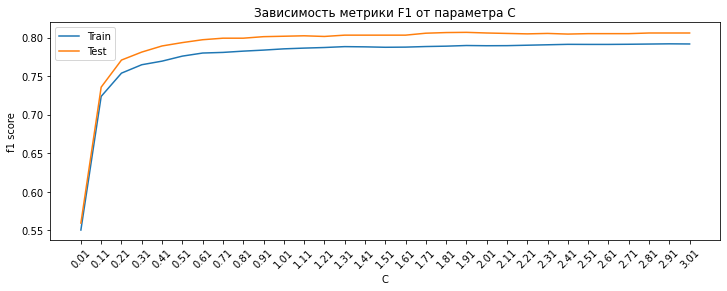

In [7]:
# Начинаем замерять время выполнения
start = time.time()

show_dependence_of_model_parameters(LogisticRegression, X_train, X_test, y_train, y_test)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

При увеличении параметра `C` метрика $F_1$ растет на обеих выборках.\
Примерно после `1` значение $F_1$ на обеих выборках стабилизируется.\
Возьмем значение `C` равным `3`-м.

In [8]:
# Создаем объект класса логистическая регрессия с параметрами C=3
logistic_regression_graph = LogisticRegression(
    C=3,
    random_state=RANDOM_STATE, 
    max_iter=MAX_ITER
)

# Обучаем модель
logistic_regression_graph.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = logistic_regression_graph.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = logistic_regression_graph.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.7919

f1_score на тестовом наборе: 0.8059

In [9]:
# Добавим значение метрики в словарь
metrics_results['graphParams'].append(f1_score_test)
# Добавим время построения графика в словарь
optimize_times['graphTimes'].append(exec_time)

Значение метрики $F_1$ на тестовой выборке улучшилось.\
Теперь сделаем подбор параметров с помощью `optuna`.

### Подбор параметров с помощью `optuna` <a id="item_lr_optuna"></a>

In [10]:
# Настроим оптимизацию гиперпараметров для логистической регрессии
def optuna_log_reg(trial):
  # Задаем пространства поиска гиперпараметров
  solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

  if (solver in ['newton-cg', 'lbfgs', 'sag'] ):
    penalty = trial.suggest_categorical('penalty_other', ['none', 'l2'])
  elif (solver == 'liblinear'):
    penalty = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
  elif (solver == 'saga'):
    penalty = trial.suggest_categorical('penalty_saga', ['elasticnet', 'l1', 'l2', 'none'])

  C = trial.suggest_uniform('C', 0.01, 3)
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)

  # Создаем модель
  model = LogisticRegression(
      solver=solver,
      penalty=penalty,        
      C=C,
      l1_ratio=l1_ratio,
      random_state=RANDOM_STATE,
      max_iter=MAX_ITER,
  )

  # Применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=CV, scoring='f1', n_jobs=N_JOBS).mean()

  return score

In [11]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем объект исследования
study_log_reg = optuna.create_study(study_name='LogisticRegression', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_log_reg.optimize(optuna_log_reg, n_trials=ATTEMPTS_COUNT, show_progress_bar=True)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

  0%|          | 0/100 [00:00<?, ?it/s]

Время выполнения: 00:00:11

In [12]:
# Выведем информацию из данных optuna о подборе гиперпараметров модели
display_optuna_info(study_log_reg)

**Наилучшие значения гиперпараметров:**

{'C': 2.9813182833987986,
 'l1_ratio': 0.9926574166566524,
 'penalty_other': 'none',
 'solver': 'sag'}


In [13]:
# Построим модель с лучшими параметрами
logistic_regression_optuna = LogisticRegression(
    C=study_log_reg.best_params['C'],
    l1_ratio=study_log_reg.best_params['l1_ratio'],
    penalty=study_log_reg.best_params['penalty_other'],
    solver=study_log_reg.best_params['solver'],
    random_state=RANDOM_STATE, 
    max_iter=MAX_ITER
)

# Обучаем модель
logistic_regression_optuna.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = logistic_regression_optuna.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = logistic_regression_optuna.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.7951

f1_score на тестовом наборе: 0.8095

In [14]:
# Добавим значение метрики в словарь
metrics_results['optunaParams'].append(f1_score_test)
# Добавим время поиска гиперпараметров в словарь
optimize_times['optunaTime'].append(exec_time)

## Дерево решений <a id="item_dtc"></a>

### Использование параметров по умолчанию <a id="item_dtc_default"></a>

In [15]:
# Создаём объект класса DecisionTreeClassifier с параметрами по умолчанию
decision_tree_classifier_default = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
)

# Обучаем дерево решений
decision_tree_classifier_default.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = decision_tree_classifier_default.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = decision_tree_classifier_default.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 1.0000

f1_score на тестовом наборе: 0.7508

In [16]:
# Добавим значение метрики в словарь
metrics_results['defaultParams'].append(f1_score_test)

Наблюдаем переобучение. \
Подберем значение глубины дерева `max_depth` с помощью графика.

### Подбор параметра `max_depth` с помощью графика <a id="item_dtc_grafic"></a>

Время выполнения: 00:00:00

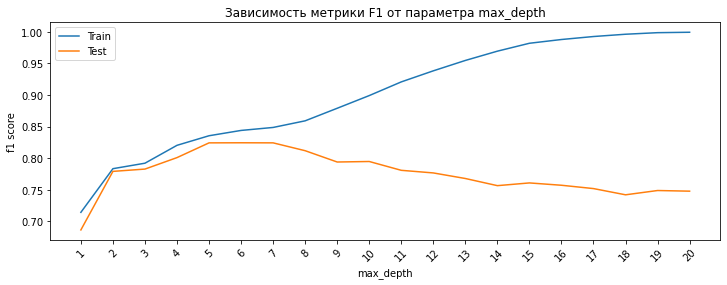

In [17]:
# Начинаем замерять время выполнения
start = time.time()

show_dependence_of_model_parameters(DecisionTreeClassifier, X_train, X_test, y_train, y_test)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

Лушим значением глубины дерева является значение `5`.\
При бОльших значениях метрика $F_1$ падает на тестовой выборке.\
А на тренировочной происходит переобучение.

In [18]:
# Создаём объект класса DecisionTreeClassifier с глубиной дерева 5
decision_tree_classifier_graph = DecisionTreeClassifier(
    max_depth=5,
    random_state=RANDOM_STATE,    
)

# Обучаем дерево решений
decision_tree_classifier_graph.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = decision_tree_classifier_graph.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = decision_tree_classifier_graph.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8356

f1_score на тестовом наборе: 0.8244

In [19]:
# Добавим значение метрики в словарь
metrics_results['graphParams'].append(f1_score_test)
# Добавим время построения графика в словарь
optimize_times['graphTimes'].append(exec_time)

Значение метрики $F_1$ на тестовой выборке улучшилось.\
Теперь сделаем подбор параметров с помощью `optuna`.

### Подбор параметров с помощью `optuna` <a id="item_dtc_optuna"></a>

In [20]:
# Настроим оптимизацию гиперпараметров для дерева решений
def optuna_dtc(trial):
  # Задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_depth = trial.suggest_int('max_depth', 3, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)

  # Создаем модель
  model = DecisionTreeClassifier(      
      criterion=criterion,      
      min_samples_leaf=min_samples_leaf,
      max_depth=max_depth,
      random_state=RANDOM_STATE,
  )

  # Применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=CV, scoring='f1', n_jobs=N_JOBS).mean()

  return score

In [21]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем объект исследования
study_dtc = optuna.create_study(study_name='DecisionTreeClassifier', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_dtc.optimize(optuna_dtc, n_trials=ATTEMPTS_COUNT, show_progress_bar=True)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

  0%|          | 0/100 [00:00<?, ?it/s]

Время выполнения: 00:00:05

In [22]:
# Выведем информацию из данных optuna о подборе гиперпараметров модели
display_optuna_info(study_dtc)

**Наилучшие значения гиперпараметров:**

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 17}


In [23]:
# Построим модель с лучшими параметрами
decision_tree_classifier_optuna = DecisionTreeClassifier(
    **study_dtc.best_params,
    #max_depth=max_depth_dtc,
    random_state=RANDOM_STATE,
)

# Обучаем дерево решений
decision_tree_classifier_optuna.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = decision_tree_classifier_optuna.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = decision_tree_classifier_optuna.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8260

f1_score на тестовом наборе: 0.8084

In [24]:
# Добавим значение метрики в словарь
metrics_results['optunaParams'].append(f1_score_test)
# Добавим время поиска гиперпараметров в словарь
optimize_times['optunaTime'].append(exec_time)

## Случайный лес <a id="item_rfc"></a>

### Использование параметров по умолчанию <a id="item_rfc_default"></a>

In [25]:
# Создаём объект класса RandomForestClassifier с параметрами по умолчанию
random_forest_classifier_default = RandomForestClassifier(
    random_state=RANDOM_STATE,
)

# Обучаем модель 
random_forest_classifier_default.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = random_forest_classifier_default.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = random_forest_classifier_default.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 1.0000

f1_score на тестовом наборе: 0.8352

In [26]:
# Добавим значение метрики в словарь
metrics_results['defaultParams'].append(f1_score_test)

Наблюдаем переобучение. \
Подберем значение глубины дерева `max_depth` с помощью графика.

### Подбор параметра `max_depth` с помощью графика <a id="item_rfc_grafic"></a>

Время выполнения: 00:00:11

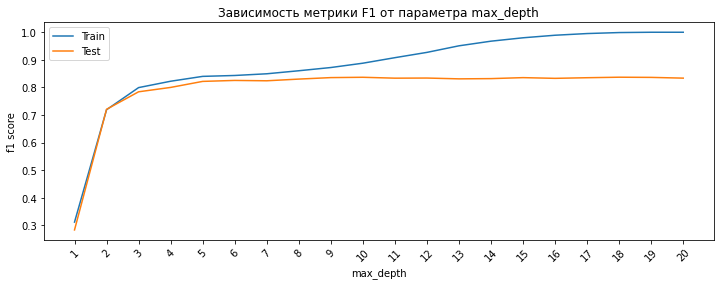

In [27]:
# Начинаем замерять время выполнения
start = time.time()

show_dependence_of_model_parameters(RandomForestClassifier, X_train, X_test, y_train, y_test)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

Лушими значениями глубины дерева являются `5`, `6` и `7`.\
При бОльших значениях метрика $F_1$ остается неизменной на тестовой выборке.\
А на тренировочной происходит переобучение.\
Возьмем значение `max_depth` равным `6`.

In [28]:
# Создаём объект класса DecisionTreeClassifier с глубиной дерева 6
random_forest_classifier_graph = RandomForestClassifier(
    max_depth=6,
    random_state=RANDOM_STATE,    
)

# Обучаем модель
random_forest_classifier_graph.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = random_forest_classifier_graph.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = random_forest_classifier_graph.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8433

f1_score на тестовом наборе: 0.8254

In [29]:
# Добавим значение метрики в словарь
metrics_results['graphParams'].append(f1_score_test)
# Добавим время построения графика в словарь
optimize_times['graphTimes'].append(exec_time)

Значение метрики $F_1$ не улучшилось.\
Но в предыдущем случае мы имели дело с переобучением.\
Теперь сделаем подбор параметров с помощью `optuna`.

### Подбор параметров с помощью `optuna` <a id="item_rfc_optuna"></a>

In [30]:
def optuna_rfc(trial):
  # Задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 50)
  max_depth = trial.suggest_int('max_depth', 3, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)

  # Создаем модель
  model = RandomForestClassifier(
    criterion=criterion,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=RANDOM_STATE
  )
  
  # Применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=CV, scoring='f1', n_jobs=N_JOBS).mean()

  return score

In [31]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем объект исследования
study_rfc = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rfc.optimize(optuna_rfc, n_trials=ATTEMPTS_COUNT, show_progress_bar=True)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

  0%|          | 0/100 [00:00<?, ?it/s]

Время выполнения: 00:04:16

In [32]:
# Выведем информацию из данных optuna о подборе гиперпараметров модели
display_optuna_info(study_rfc)

**Наилучшие значения гиперпараметров:**

{'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 4,
 'n_estimators': 450}


In [33]:
# Построим модель с лучшими параметрами
random_forest_classifier_optuna = RandomForestClassifier(
    **study_rfc.best_params,    
    random_state=RANDOM_STATE,
)

# Обучаем дерево решений
random_forest_classifier_optuna.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = random_forest_classifier_optuna.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = random_forest_classifier_optuna.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8858

f1_score на тестовом наборе: 0.8337

In [34]:
# Добавим значение метрики в словарь
metrics_results['optunaParams'].append(f1_score_test)
# Добавим время поиска гиперпараметров в словарь
optimize_times['optunaTime'].append(exec_time)

## Градиентный бустинг <a id="item_gbc"></a>

### Использование параметров по умолчанию <a id="item_gbc_default"></a>

In [35]:
# Создадим объект класса GradientBoostingClassifier с параметрами по умолчанию
gradient_boosting_classifier_default = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
)

# Обучаем модель
gradient_boosting_classifier_default.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = gradient_boosting_classifier_default.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = gradient_boosting_classifier_default.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8413

f1_score на тестовом наборе: 0.8230

In [36]:
# Добавим значение метрики в словарь
metrics_results['defaultParams'].append(f1_score_test)

### Подбор параметра `max_depth` с помощью графика <a id="item_gbc_grafic"></a>

Время выполнения: 00:01:11

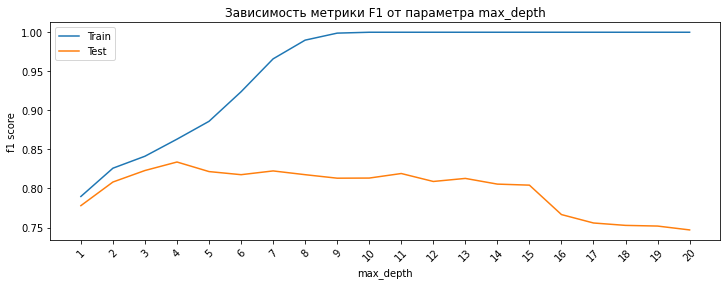

In [37]:
# Начинаем замерять время выполнения
start = time.time()

show_dependence_of_model_parameters(GradientBoostingClassifier, X_train, X_test, y_train, y_test)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

Лушим значением глубины дерева является значение `4`.\
При бОльших значениях метрика $F_1$ падает на тестовой выборке.\
А на тренировочной происходит переобучение.

In [38]:
# Создадим объект класса GradientBoostingClassifier с параметром max_depth = 4
gradient_boosting_classifier_graph = GradientBoostingClassifier(
    max_depth=4,
    random_state=RANDOM_STATE,
)

# Обучаем модель
gradient_boosting_classifier_graph.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = gradient_boosting_classifier_graph.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = gradient_boosting_classifier_graph.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8631

f1_score на тестовом наборе: 0.8339

In [39]:
# Добавим значение метрики в словарь
metrics_results['graphParams'].append(f1_score_test)
# Добавим время построения графика в словарь
optimize_times['graphTimes'].append(exec_time)

Значение метрики $F_1$ на тестовой выборке улучшилось.\
Теперь сделаем подбор параметров с помощью `optuna`.

### Подбор параметров с помощью `optuna` <a id="item_gbc_optuna"></a>

In [40]:
def optuna_gbc(trial):
  # Задаем пространства поиска гиперпараметров
  learning_rate = trial.suggest_float('learning_rate', 0, 1)
  criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 50)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)
  max_depth = trial.suggest_int('max_depth', 3, 10, 1)

  # Создаем модель
  model = GradientBoostingClassifier(
    learning_rate=learning_rate,
    criterion=criterion,
    n_estimators=n_estimators,    
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=RANDOM_STATE,
  )
  
  # Применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=CV, scoring='f1', n_jobs=N_JOBS).mean()

  return score

In [41]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем объект исследования
study_gbc = optuna.create_study(study_name='GradientBoostingClassifier', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_gbc.optimize(optuna_gbc, n_trials=ATTEMPTS_COUNT, show_progress_bar=True)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

  0%|          | 0/100 [00:00<?, ?it/s]

Время выполнения: 00:05:36

In [42]:
# Выведем информацию из данных optuna о подборе гиперпараметров модели
display_optuna_info(study_gbc)

**Наилучшие значения гиперпараметров:**

{'criterion': 'squared_error',
 'learning_rate': 0.07240483040655268,
 'max_depth': 4,
 'min_samples_leaf': 9,
 'n_estimators': 150}


In [43]:
# Построим модель с лучшими параметрами
gradient_boosting_classifier_optuna = GradientBoostingClassifier(
    **study_gbc.best_params,
    random_state=RANDOM_STATE,
)

# Обучаем дерево решений
gradient_boosting_classifier_optuna.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = gradient_boosting_classifier_optuna.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = gradient_boosting_classifier_optuna.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8663

f1_score на тестовом наборе: 0.8296

In [44]:
# Добавим значение метрики в словарь
metrics_results['optunaParams'].append(f1_score_test)
# Добавим время поиска гиперпараметров в словарь
optimize_times['optunaTime'].append(exec_time)

## Стекинг <a id="item_sc"></a>

### Использование параметров метамодели по умолчанию <a id="item_sc_default"></a>

Для стекинга возьмем модели логистической регрессии, дерева решений и градиентного бустинга, \
которые показали лучшие метрики на тестовой выборке.

In [47]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    #('logistic_regression_graph', logistic_regression_graph),
    ('logistic_regression_optuna', logistic_regression_optuna),
    ('decision_tree_classifier_graph', decision_tree_classifier_graph),
    #('decision_tree_classifier_optuna',  decision_tree_classifier_optuna),
    ('gradient_boosting_classifier_graph', gradient_boosting_classifier_graph),
    #('gradient_boosting_classifier_optuna', gradient_boosting_classifier_optuna),
]

# Создаем объект класса StackingClassifier с параметрами метамодели по умолчанию
stacking_classifier_default = StackingClassifier(
    # базовые модели в стекинге
    estimators=estimators, 
    # метамодель
    final_estimator=DecisionTreeClassifier(
        random_state=RANDOM_STATE,
    ),    
)

# Обучаем модель
stacking_classifier_default.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = stacking_classifier_default.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = stacking_classifier_default.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.7733

f1_score на тестовом наборе: 0.7645

In [48]:
# Добавим значение метрики в словарь
metrics_results['defaultParams'].append(f1_score_test)

### Подбор параметра `max_depth` с помощью графика <a id="item_sc_grafic"></a>

Время выполнения: 00:00:23

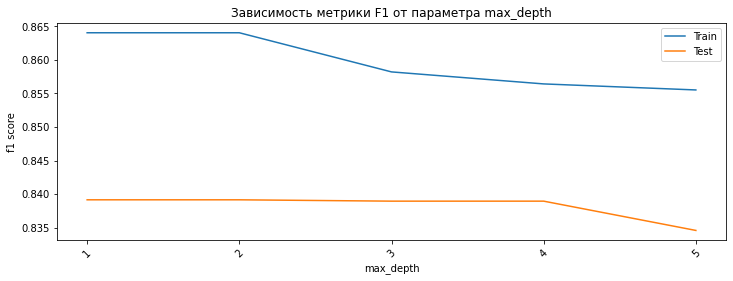

In [49]:
# Начинаем замерять время выполнения
start = time.time()

show_dependence_of_model_parameters(
    StackingClassifier, X_train, X_test, y_train, y_test, estimators, DecisionTreeClassifier
)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

Оптимальным значением глубины дерева является значение `4`.\
Далее метрика $F_1$ падает на тестовой выборке.

In [50]:
# Создаем объект класса StackingClassifier с параметром max_depth=4
stacking_classifier_graph = StackingClassifier(
    # базовые модели в стекинге
    estimators=estimators, 
    # метамодель
    final_estimator=DecisionTreeClassifier(
        max_depth=4,
        random_state=RANDOM_STATE,
    ),    
)

# Обучаем модель
stacking_classifier_graph.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = stacking_classifier_graph.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = stacking_classifier_graph.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8564

f1_score на тестовом наборе: 0.8390

In [51]:
# Добавим значение метрики в словарь
metrics_results['graphParams'].append(f1_score_test)
# Добавим время построения графика в словарь
optimize_times['graphTimes'].append(exec_time)

Значение метрики $F_1$ улучшилось на тестовой выборке.\
Теперь сделаем подбор параметров с помощью `optuna`.

### Подбор параметров метамодели с помощью `optuna` <a id="item_sc_optuna"></a>

In [52]:
# Настроим оптимизацию гиперпараметров для дерева решений
def optuna_sc(trial):
  # Задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)
  max_depth = trial.suggest_int('max_depth', 2, 6, 1)
  
  # Создаем модель
  model = StackingClassifier(
    # базовые модели в стекинге
    estimators=estimators, 
    # метамодель
    final_estimator=DecisionTreeClassifier(
      criterion=criterion,      
      min_samples_leaf=min_samples_leaf,
      max_depth=max_depth,
      random_state=RANDOM_STATE,
    ),    
  )

  # Применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=CV, scoring='f1', n_jobs=N_JOBS).mean()

  return score

In [53]:
# Начинаем замерять время выполнения
start = time.time()

# Создаем объект исследования
study_sc = optuna.create_study(study_name='StackingClassifier', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_sc.optimize(optuna_sc, n_trials=ATTEMPTS_COUNT, show_progress_bar=True)

# Заканчиваем замерять время выполнения
end = time.time()
exec_time = get_exec_time(start, end)
# Выводим время выполнения
display_exec_time(exec_time)

  0%|          | 0/100 [00:00<?, ?it/s]

Время выполнения: 00:11:35

In [54]:
# Выведем информацию из данных optuna о подборе гиперпараметров модели
display_optuna_info(study_sc)

**Наилучшие значения гиперпараметров:**

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 13}


In [55]:
# Построим модель с лучшими параметрами
stacking_classifier_optuna = StackingClassifier(
    # базовые модели в стекинге
    estimators=estimators, 
    # метамодель
    final_estimator=DecisionTreeClassifier(
      **study_sc.best_params,
      random_state=RANDOM_STATE,
    ),    
  )

# Обучаем дерево решений
stacking_classifier_optuna.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = stacking_classifier_optuna.predict(X_train)
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = stacking_classifier_optuna.predict(X_test)
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
display_f1_score(f1_score_train, 'train')
display_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.8641

f1_score на тестовом наборе: 0.8392

In [56]:
# Добавим значение метрики в словарь
metrics_results['optunaParams'].append(f1_score_test)
# Добавим время поиска гиперпараметров в словарь
optimize_times['optunaTime'].append(exec_time)

## Выводы <a id="item_results"></a>

**Время поиска гиперпараметров для каждой модели**

,model,graphTimes,optunaTime
0,LogisticRegression,00:00:01,00:00:11
1,DecisionTreeClassifier,00:00:00,00:00:05
2,RandomForestClassifier,00:00:11,00:04:16
3,GradientBoostingClassifier,00:01:11,00:05:36
4,StackingClassifier,00:00:23,00:11:35


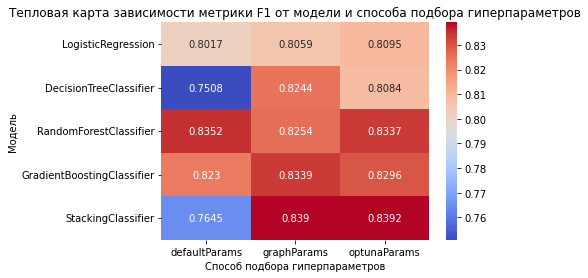

In [57]:
# Выведем итоговые данные с метриками и временем поиска гиперпараметров
display_metrics_results(metrics_results, optimize_times)

Лучший результат показал `StackingClassifier` с подбором гиперпараметров через `optuna` \
$F_1 = 0.8392$.\
Но с небольшим отрывом от той же модели `StackingClassifier`, с подбором глубины дерева с помощью графика \
$F_1 = 0.839$.\
Поиск параметра по графику при этом занимает значительно меньше времени\
(по графику 23 секунды, с помощью `optuna` 11 минут).

Для других моделей также можно заметить, что поиск оптимального значения глубины дерева \
(или параметра `C` для линейной регрессии) по графику дает сравнимый, а иногда и более лучший результат.

Чтобы получить больше пользы от `optuna`, нужно поэтапно корректировать область поиска параметров.

In [2]:
navigation.display_backlink()

**Вернуться к файлу &laquo;[Главная](./1_main.ipynb)&raquo;**